# Analyses Fabian Sanchez
Studentennr: 202187874

Groep: 2 VC


### Prerequisites

In [373]:
pip install pandasql

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\sfsan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [374]:
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

from sqlalchemy import create_engine

In [375]:
# verbinding
server = r"DESKTOP-1DRSSG0\SQLEXPRESS" 
database = "DEP1_DWH"

engine = create_engine("mssql+pyodbc://@{}/{}?driver=ODBC+Driver+17+for+SQL+Server".format(server, database))

## Gemakkelijk 2

We beschikken voor de dataset van 1300 residentiële gebruikers jammer genoeg niet over de
overeenkomstige piekverbruiken.
Daarom zullen we als benadering voor de maandpiek het volgende gebruiken, namelijk het maximum
verbruik voor één kwartier per maand * 4.
We willen verifiëren of dat wel een goede benadering is.

Maak gebruik van de 2 bijhorende bestanden (van gebruiker 1301) om te controleren of deze aanpak
wel een goede benadering is. Je moet de data van gebruiker 1301 niet toevoegen aan de DWH.
Bepaal zelf welke metriek je hierbij best kan gebruiken. Denk daarbij aan de metrieken die aan bod
komen in ML

### Preprocess piekvermogens

In [376]:
historiek_piekvermogen_1301 = pd.read_csv("../data/input/Sprint2/Historiek_piekvermogen_elektriciteit_1301_20240201_20250331.csv", sep=";")
historiek_piekvermogen_1301.drop(columns=["Van (tijdstip)", "Tot (tijdstip)", "Meter", "Validatiestatus", "Omschrijving"], inplace=True)
historiek_piekvermogen_1301.head()

,Van (datum),Tot (datum),EAN-code,Metertype,Register,Volume,Eenheid
0,01-02-2024,01-03-2024,1301,Digitale meter,Piekvermogen,"4,349",kW
1,01-03-2024,01-04-2024,1301,Digitale meter,Piekvermogen,"3,950",kW
2,01-04-2024,01-05-2024,1301,Digitale meter,Piekvermogen,"9,308",kW
3,01-05-2024,01-06-2024,1301,Digitale meter,Piekvermogen,"3,532",kW
4,01-06-2024,01-07-2024,1301,Digitale meter,Piekvermogen,"4,456",kW


In [377]:
historiek_piekvermogen_1301['Volume'] = historiek_piekvermogen_1301['Volume'].str.replace(",", ".")

historiek_piekvermogen_1301['Volume'] = historiek_piekvermogen_1301['Volume'].astype(float)

historiek_piekvermogen_1301["Van (datum)"] = pd.to_datetime(historiek_piekvermogen_1301["Van (datum)"], format='%d-%m-%Y')

historiek_piekvermogen_1301.head()

,Van (datum),Tot (datum),EAN-code,Metertype,Register,Volume,Eenheid
0,2024-02-01,01-03-2024,1301,Digitale meter,Piekvermogen,4.349,kW
1,2024-03-01,01-04-2024,1301,Digitale meter,Piekvermogen,3.950,kW
2,2024-04-01,01-05-2024,1301,Digitale meter,Piekvermogen,9.308,kW
3,2024-05-01,01-06-2024,1301,Digitale meter,Piekvermogen,3.532,kW
4,2024-06-01,01-07-2024,1301,Digitale meter,Piekvermogen,4.456,kW


In [378]:
historiek_piekvermogen_1301 = sqldf('''
                                    select Volume as MaandPiek,
                                        strftime('%Y-%m', "Van (datum)") as maand
                                    from historiek_piekvermogen_1301   
                                  ''')

historiek_piekvermogen_1301.head(10)

,MaandPiek,maand
0,4.349,2024-02
1,3.950,2024-03
2,9.308,2024-04
3,3.532,2024-05
4,4.456,2024-06
5,4.402,2024-07
6,3.256,2024-08
7,4.241,2024-09
8,3.054,2024-10
9,3.622,2024-11


In [379]:
historiek_piekvermogen_1301.head(20)

,MaandPiek,maand
0,4.349,2024-02
1,3.950,2024-03
2,9.308,2024-04
3,3.532,2024-05
4,4.456,2024-06
5,4.402,2024-07
6,3.256,2024-08
7,4.241,2024-09
8,3.054,2024-10
9,3.622,2024-11


### Preprocess verbruikshistoriek

In [380]:
verbruikshistoriek_1301 = pd.read_csv("../data/input/Sprint2/Verbruikshistoriek_elektriciteit_1301_20240513_20250303_kwartiertotalen.csv", sep=";")

verbruikshistoriek_1301.head()

,Van (datum),Van (tijdstip),Tot (datum),Tot (tijdstip),EAN-code,Meter,Metertype,Register,Volume,Eenheid,Validatiestatus,Omschrijving
0,13-05-2024,00:00:00,13-05-2024,00:15:00,1301,NaN,Digitale meter,Afname Nacht,NaN,kWh,Geen verbruik,NaN
1,13-05-2024,00:00:00,13-05-2024,00:15:00,1301,NaN,Digitale meter,Injectie Nacht,NaN,kWh,Geen verbruik,NaN
2,13-05-2024,00:15:00,13-05-2024,00:30:00,1301,NaN,Digitale meter,Afname Nacht,"0,026",kWh,Uitgelezen,NaN
3,13-05-2024,00:15:00,13-05-2024,00:30:00,1301,NaN,Digitale meter,Injectie Nacht,"0,000",kWh,Uitgelezen,NaN
4,13-05-2024,00:30:00,13-05-2024,00:45:00,1301,NaN,Digitale meter,Afname Nacht,"0,109",kWh,Uitgelezen,NaN


In [381]:

verbruikshistoriek_1301["Van (datum)"] = pd.to_datetime(verbruikshistoriek_1301["Van (datum)"], format='%d-%m-%Y')
verbruikshistoriek_1301.head(20)

,Van (datum),Van (tijdstip),Tot (datum),Tot (tijdstip),EAN-code,Meter,Metertype,Register,Volume,Eenheid,Validatiestatus,Omschrijving
0,2024-05-13,00:00:00,13-05-2024,00:15:00,1301,NaN,Digitale meter,Afname Nacht,NaN,kWh,Geen verbruik,NaN
1,2024-05-13,00:00:00,13-05-2024,00:15:00,1301,NaN,Digitale meter,Injectie Nacht,NaN,kWh,Geen verbruik,NaN
2,2024-05-13,00:15:00,13-05-2024,00:30:00,1301,NaN,Digitale meter,Afname Nacht,"0,026",kWh,Uitgelezen,NaN
3,2024-05-13,00:15:00,13-05-2024,00:30:00,1301,NaN,Digitale meter,Injectie Nacht,"0,000",kWh,Uitgelezen,NaN
4,2024-05-13,00:30:00,13-05-2024,00:45:00,1301,NaN,Digitale meter,Afname Nacht,"0,109",kWh,Uitgelezen,NaN
5,2024-05-13,00:30:00,13-05-2024,00:45:00,1301,NaN,Digitale meter,Injectie Nacht,"0,000",kWh,Uitgelezen,NaN
6,2024-05-13,00:45:00,13-05-2024,01:00:00,1301,NaN,Digitale meter,Afname Nacht,"0,025",kWh,Uitgelezen,NaN
7,2024-05-13,00:45:00,13-05-2024,01:00:00,1301,NaN,Digitale meter,Injectie Nacht,"0,000",kWh,Uitgelezen,NaN
8,2024-05-13,01:00:00,13-05-2024,01:15:00,1301,NaN,Digitale meter,Afname Nacht,"0,037",kWh,Uitgelezen,NaN
9,2024-05-13,01:00:00,13-05-2024,01:15:00,1301,NaN,Digitale meter,Injectie Nacht,"0,000",kWh,Uitgelezen,NaN


In [382]:
verbruikshistoriek_1301 = sqldf('''
                                    select max(Volume) as max_volume,
                                          strftime('%Y-%m', "Van (datum)") as maand 
                                   from verbruikshistoriek_1301
                                   where Register like 'Afname%'
                                   group by maand
                                   order by maand
                                '''    )

In [383]:
verbruikshistoriek_1301.head(10)

,max_volume,maand
0,"0,842",2024-05
1,"1,115",2024-06
2,"1,102",2024-07
3,"0,814",2024-08
4,"1,060",2024-09
5,"0,764",2024-10
6,"0,905",2024-11
7,"1,676",2024-12
8,"0,995",2025-01
9,"0,960",2025-02


In [384]:
# float
verbruikshistoriek_1301['max_volume'] = verbruikshistoriek_1301['max_volume'].str.replace(",", ".")

verbruikshistoriek_1301['max_volume'] = verbruikshistoriek_1301['max_volume'].astype(float) * 4

In [385]:
# maart 2025 had geen data

verbruikshistoriek_1301.drop(labels=[10], inplace=True)

In [386]:
verbruikshistoriek_1301.head(15)

,max_volume,maand
0,3.368,2024-05
1,4.460,2024-06
2,4.408,2024-07
3,3.256,2024-08
4,4.240,2024-09
5,3.056,2024-10
6,3.620,2024-11
7,6.704,2024-12
8,3.980,2025-01
9,3.840,2025-02


### Merge

In [387]:
df_vergelijking = pd.merge(historiek_piekvermogen_1301, verbruikshistoriek_1301, on='maand')
df_vergelijking = df_vergelijking.rename(columns={'max_volume': 'MaxVolume', 'maand': 'Maand'})
df_vergelijking = df_vergelijking[['Maand', 'MaandPiek', 'MaxVolume']]
df_vergelijking.head(15)

,Maand,MaandPiek,MaxVolume
0,2024-05,3.532,3.368
1,2024-06,4.456,4.460
2,2024-07,4.402,4.408
3,2024-08,3.256,3.256
4,2024-09,4.241,4.240
5,2024-10,3.054,3.056
6,2024-11,3.622,3.620
7,2024-12,6.706,6.704
8,2025-01,3.977,3.980
9,2025-02,3.838,3.840


### Visuele voorstelling


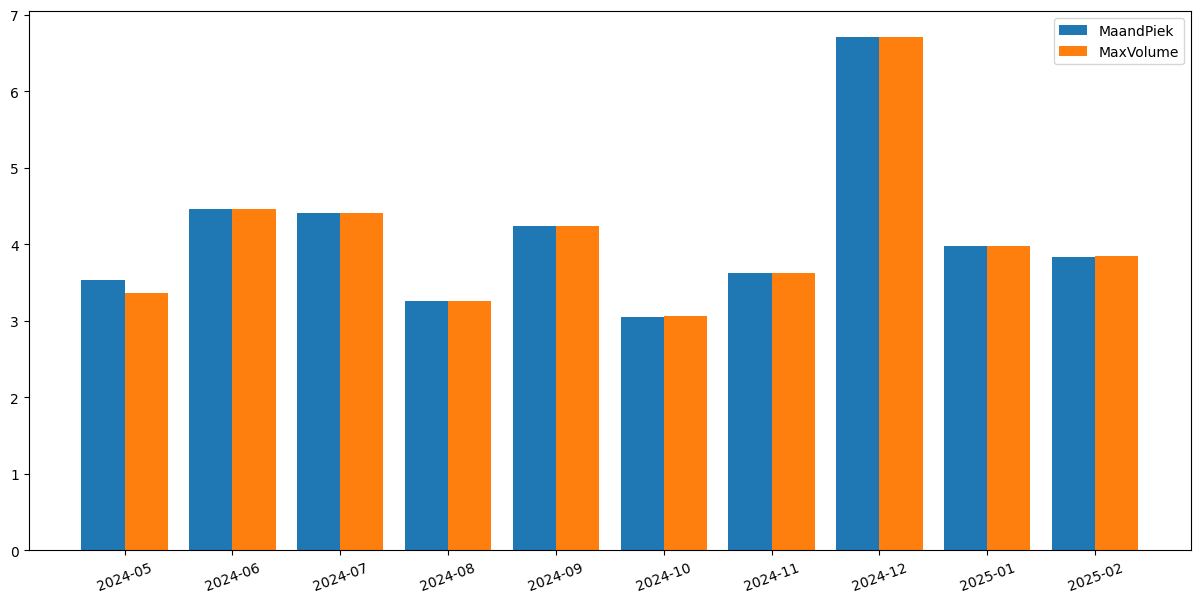

In [388]:
x = np.arange(len(df_vergelijking))

plt.figure(figsize=(15, 7))
plt.bar(x - 0.2, df_vergelijking['MaandPiek'], width=0.4, label='MaandPiek')
plt.bar(x + 0.2, df_vergelijking['MaxVolume'], width=0.4, label='MaxVolume')

plt.xticks(x, df_vergelijking['Maand'], rotation=20)
plt.legend()
plt.show()

### Statistische metrieken

In [389]:
waarnemingen = df_vergelijking['MaandPiek']
voorspellingen = df_vergelijking['MaxVolume']

rmse = root_mean_squared_error(waarnemingen, voorspellingen)
mape = mean_absolute_percentage_error(waarnemingen, voorspellingen)

print("RMSE:",rmse)
print("MAPE:",mape)

RMSE: 0.051936499689524754
MAPE: 0.0051709834932147205


### Conclusie

Het is aan de hand van zowel de histogram als de RMSE en MAPE waarden duidelijk dat de voorspellingen van de piekvermogen zeer goed zijn voor gebruiker 1301. Dit zal waarschijnlijk geen toeval zijn, maar we dienen voorzichtig te zijn: de steekproef van 1 gebruiker is te klein om uitspraken te doen over de gehele populatie.

## Gemiddeld 2

Volgens Fluvius bedraagt de facturatiepiek voor een gemiddeld gezin 3.5 tot 4 kW en draait het verbruik
rond 3500 kWh per jaar (https://www.fluvius.be/nl/blog/capaciteitstarief/capaciteitstarief-nieuweberekening-nettarieven-piekvermogen)
In de onderstaande plot en de onderstaande tabel worden de netbeheerkosten voor 2023, 2024 en
2025 vergeleken. Begin met het maken van de plot en werk verder met de data nodig voor het maken
van de plot om de onderstaande tabel te maken. In de tabel wordt de relatieve stijging tussen 2023 en
2025 berekend.
We gaan bij de berekeningen uit van een gemiddelde klant met een facturatiepiek van 4kW en een
jaarlijks verbruik van 3500 kWh. Bovendien gaan we ervan uit dat

• Fluvius Antwerpen = Fluvius (Antwerpen)
• Fluvius Limburg = Fluvius (Limburg)
• Fluvius Imewo = Fluvius (Imewo)
• Intergem = Fluvius (Midden-Vlaanderen)
• Iveka = Fluvius (Kempen)
• Iverlek = Fluvius (Zenne-Dijle)
• Gaselwest = Fluvius (West)

De andere netbeheerders worden genegeerd.

In [390]:
table_name = "FactNetworkCosts"
df_FactNetworkCosts = pd.read_sql(f"SELECT * FROM {table_name}", con=engine)
df_FactNetworkCosts.head()


,NetworkCostKey,DateKey,NetworkOperator,CapacityTariff_DigitalMeter,ConsumptionTariff_DigitalMeter_Normal,ConsumptionTariff_DigitalMeter_ExclusiveNight,CapacityTariff_ClassicMeter,ConsumptionTariff_ClassicMeter_Normal,ConsumptionTariff_ClassicMeter_ExclusiveNight,ProsumerTariff,DataManagementTariff_YearlyMonthlyReadMeters,DataManagementTariff_QuarterlyReadMeters
0,3,20230101,Fluvius Antwerpen,40.03,3.74,2.60,100.07,5.71,4.57,38.56,13.39,14.53
1,4,20230101,Fluvius Limburg,37.65,3.94,2.82,94.13,6.08,4.96,41.11,13.39,14.53
2,5,20230101,Fluvius West,41.08,3.82,2.72,102.70,6.11,5.02,41.28,13.39,14.53
3,6,20230101,Gaselwest,48.76,4.98,3.37,121.90,7.41,5.79,50.05,13.39,14.53
4,7,20230101,Imewo,43.51,4.01,2.83,108.77,6.24,5.05,42.12,13.39,14.53


In [391]:
df_FactNetworkCosts = sqldf('''
                                                select *
                                                from df_FactNetworkCosts
                                                where NetworkOperator not in ('PBE', 'Sibelgas', 'Fluvius (Halle-Vilvoorde)', 'Gaselwest')
                                                ''')
df_FactNetworkCosts.head()

,NetworkCostKey,DateKey,NetworkOperator,CapacityTariff_DigitalMeter,ConsumptionTariff_DigitalMeter_Normal,ConsumptionTariff_DigitalMeter_ExclusiveNight,CapacityTariff_ClassicMeter,ConsumptionTariff_ClassicMeter_Normal,ConsumptionTariff_ClassicMeter_ExclusiveNight,ProsumerTariff,DataManagementTariff_YearlyMonthlyReadMeters,DataManagementTariff_QuarterlyReadMeters
0,3,20230101,Fluvius Antwerpen,40.03,3.74,2.60,100.07,5.71,4.57,38.56,13.39,14.53
1,4,20230101,Fluvius Limburg,37.65,3.94,2.82,94.13,6.08,4.96,41.11,13.39,14.53
2,5,20230101,Fluvius West,41.08,3.82,2.72,102.70,6.11,5.02,41.28,13.39,14.53
3,7,20230101,Imewo,43.51,4.01,2.83,108.77,6.24,5.05,42.12,13.39,14.53
4,8,20230101,Intergem,39.06,3.66,2.60,97.65,5.77,4.71,38.97,13.39,14.53


In [392]:
df_FactNetworkCosts = df_FactNetworkCosts.replace({'Fluvius Antwerpen': 'Fluvius (Antwerpen)', 'Fluvius Limburg': 'Fluvius (Limburg)', 'Imewo': 'Fluvius (Imewo)', 'Intergem': 'Fluvius (Midden-Vlaanderen)', 'Iveka': 'Fluvius (Kempen)', 'Iverlek': 'Fluvius (Zenne-Dijle)', 'Fluvius West': 'Fluvius (West)'})
df_FactNetworkCosts.head()

,NetworkCostKey,DateKey,NetworkOperator,CapacityTariff_DigitalMeter,ConsumptionTariff_DigitalMeter_Normal,ConsumptionTariff_DigitalMeter_ExclusiveNight,CapacityTariff_ClassicMeter,ConsumptionTariff_ClassicMeter_Normal,ConsumptionTariff_ClassicMeter_ExclusiveNight,ProsumerTariff,DataManagementTariff_YearlyMonthlyReadMeters,DataManagementTariff_QuarterlyReadMeters
0,3,20230101,Fluvius (Antwerpen),40.03,3.74,2.60,100.07,5.71,4.57,38.56,13.39,14.53
1,4,20230101,Fluvius (Limburg),37.65,3.94,2.82,94.13,6.08,4.96,41.11,13.39,14.53
2,5,20230101,Fluvius (West),41.08,3.82,2.72,102.70,6.11,5.02,41.28,13.39,14.53
3,7,20230101,Fluvius (Imewo),43.51,4.01,2.83,108.77,6.24,5.05,42.12,13.39,14.53
4,8,20230101,Fluvius (Midden-Vlaanderen),39.06,3.66,2.60,97.65,5.77,4.71,38.97,13.39,14.53


### Berekening jaarlijkse kost van een gemiddelde klant

Gemiddeld verbruik is 3500 kWh, gemiddelde facturatiepiek 4 kW.

Ik ging uit van een digitale meter. Ook bracht ik het prosumententarief in rekening met een installatie van 2.9 KVA.

Verbruikskosten zijn in cent uitgedrukt, dus wordt 4 -> 0,04 en 3500 -> 35 om naar euro te rekenen.
Datamanagementkosten en Prosumententarief zijn per jaar, in euro.


In [393]:
df_FactNetworkCosts = sqldf(
    '''
    select DateKey, NetworkOperator, 
    (CapacityTariff_DigitalMeter*0.04 +
        ConsumptionTariff_DigitalMeter_Normal*35 +
        ProsumerTariff*2.9 +
        DataManagementTariff_YearlyMonthlyReadMeters +
        DataManagementTariff_QuarterlyReadMeters) 
    as NetCost
    from df_FactNetworkCosts
    order by NetworkOperator, DateKey
    '''
)
df_FactNetworkCosts.head(25)


,DateKey,NetworkOperator,NetCost
0,20230101,Fluvius (Antwerpen),272.2452
1,20240101,Fluvius (Antwerpen),324.3146
2,20250101,Fluvius (Antwerpen),418.3474
3,20230101,Fluvius (Imewo),292.1584
4,20240101,Fluvius (Imewo),336.3498
5,20250101,Fluvius (Imewo),448.0466
6,20230101,Fluvius (Kempen),302.0612
7,20240101,Fluvius (Kempen),332.6700
8,20250101,Fluvius (Kempen),438.0470
9,20230101,Fluvius (Limburg),286.5450


In [394]:
df_FactNetworkCosts = sqldf('''
    select 
        a.*,
        case 
            when a.datekey = 20250101 then 
                round(((a.netcost - b.netcost) / b.netcost * 100), 2) || '%' 
            else null
        end as difference2023vs2025
    from 
        df_FactNetworkCosts a
    left join 
        (select networkoperator, netcost from df_FactNetworkCosts where datekey = 20230101) b
    on 
        a.networkoperator = b.networkoperator
''')

In [395]:
df_FactNetworkCosts.head(25)

,DateKey,NetworkOperator,NetCost,difference2023vs2025
0,20230101,Fluvius (Antwerpen),272.2452,None
1,20240101,Fluvius (Antwerpen),324.3146,None
2,20250101,Fluvius (Antwerpen),418.3474,53.67%
3,20230101,Fluvius (Imewo),292.1584,None
4,20240101,Fluvius (Imewo),336.3498,None
5,20250101,Fluvius (Imewo),448.0466,53.36%
6,20230101,Fluvius (Kempen),302.0612,None
7,20240101,Fluvius (Kempen),332.6700,None
8,20250101,Fluvius (Kempen),438.0470,45.02%
9,20230101,Fluvius (Limburg),286.5450,None


## Grafische voorstelling

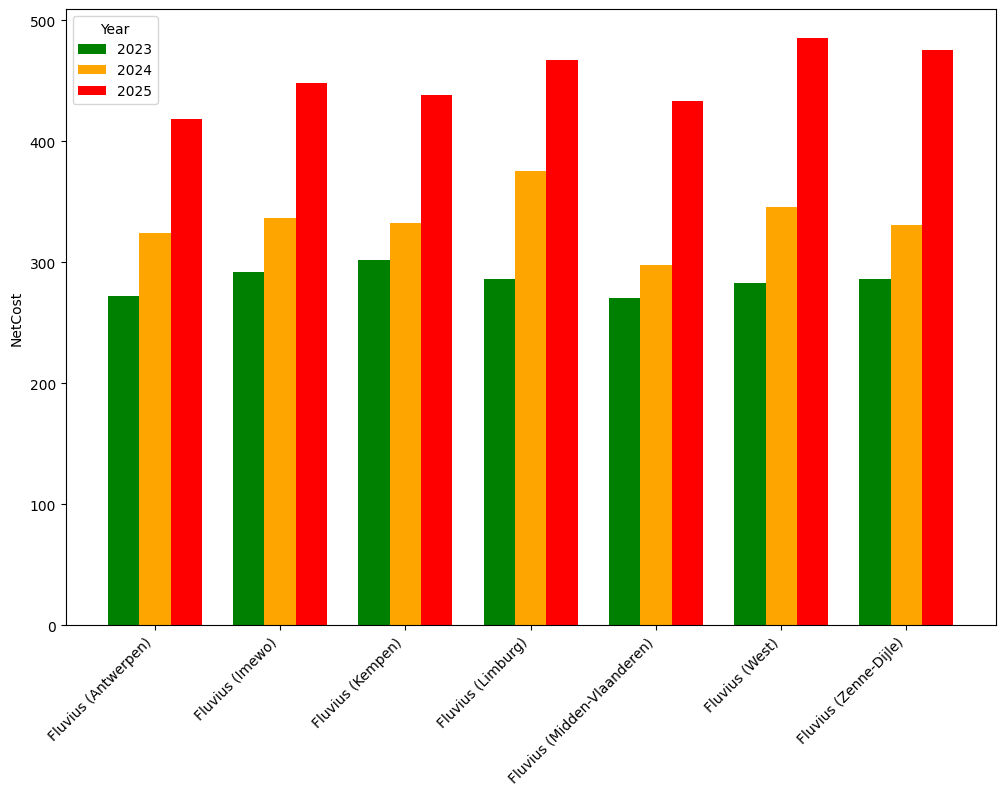

In [396]:
df_FactNetworkCosts['Year'] = df_FactNetworkCosts['DateKey'].astype(str).str[:4]

fig, ax = plt.subplots(figsize=(12, 8))

operators = df_FactNetworkCosts['NetworkOperator'].unique()
x_pos = np.arange(len(operators))
width = 0.25

colors = {'2023': 'green', '2024': 'orange', '2025': 'red'}

for i, year in enumerate(['2023', '2024', '2025']):
    data = df_FactNetworkCosts[df_FactNetworkCosts['Year'] == year]
    values = [data[data['NetworkOperator'] == op]['NetCost'].values[0] for op in operators]
    ax.bar(x_pos + (i-1)*width, values, width=width, color=colors[year], label=year)

ax.set_xticks(x_pos)
ax.set_xticklabels(operators, rotation=45, ha='right')
ax.set_ylabel('NetCost')
ax.legend(title='Year')

plt.show()
